In [108]:
import pandas as pd
import numpy as np
import numpy.typing as npt
import seaborn as sns
import matplotlib.pyplot as plt
import os

import re
import unicodedata
import pprint 

from bs4 import BeautifulSoup


In [109]:
# setting constants
PROJECT_ROOT = os.path.split(os.getcwd())[0]
DATA_RAW = 'data'
DATA_PRO = 'data/processed'

# names of datasets
QC23_raw = 'QC23_Dataset'
QC23_clean = 'cleaned_QC23_Dataset'
QC23_prob = 'qc23_prob'
QC23_prob_pro = 'qc23_prob_pro'
QC23_log = 'qc23_log'
PROB_RESP_COUNT = 'problem_response_counts'
STUD_RESP_COUNT = 'student_response_counts'
PROB_ASSIST_MAP = 'problem_assistment_mapping'

# names of file types
CSV = '.csv'
JSON = '.json'

# names of columns
PROBLEM_LOG_ID = 'problem_log_id'
STUDENT_USER_ID = 'student_user_id'
ASSIGNMENT_ID = 'assignment_id'
ASSISTMENT_ID = 'assistment_id'
ASSIGNMENT_COMPLETION = 'assignment_completion'
PROBLEM_ID = 'problem_id'
SKILL_CODE = 'skill_code'
SKILL_NAME = 'skill_name'
SKILL_BUILDER = 'is_flat_skill_builder'
SCAFFOLD = 'is_scaffold'
PROBLEM_START_TIME = 'problem_start_time'
PROBLEM_END_TIME = 'problem_end_time'
PROBLEM_TYPE_ID = 'problem_type_id'
PROBLEM_TYPE = 'problem_type'
PROBLEM_ORDER = 'problem_order'
PROBLEM_BODY = 'problem_body'
ANSWER_TEXT = 'answer_text'
CORRECTNESS = 'correctness'

# Dtypes:
EXPECTED_DTYPES = {'problem_log_id': 'int64',
        'student_user_id': 'int64',
        'prior_problems_count': 'int64',
        'prior_pr10_avg_correctness': 'float64',
        'prior_5pr_avg_correctness': 'float64',
        'prior_pr_avg_correctness': 'float64',
        'problem_set_id': 'int64',
        'student_class_id': 'int64',
        'teacher_id': 'int64',
        'assignment_id': 'int64',
        'assignment_start_time': 'object',
        'assignment_end_time': 'object',
        'assignment_completion': 'int64',
        'assistment_id': 'int64',
        'problem_id': 'int64',
        'problem_set_name': 'object',
        'content_source': 'object',
        'is_flat_skill_builder': 'int64',
        'is_scaffold': 'int64',
        'problem_type_id': 'int64',
        'skill_code': 'object',
        'skill_name': 'object',
        'problem_type': 'object',
        'problem_body': 'object',
        'problem_order': 'int64',
        'problem_start_time': 'object',
        'problem_end_time': 'object',
        'answer_text': 'object',
        'correctness': 'float64',
        'hint_count': 'int64',
        'bottom_hint': 'bool',
        'first_action_is_attempt': 'float64'
        }


### Problem Analysis

In [110]:
problem_df = pd.read_csv(os.path.join(PROJECT_ROOT, DATA_PRO, QC23_prob + CSV))
problem_resp_count = pd.read_csv(os.path.join(PROJECT_ROOT, DATA_PRO, PROB_RESP_COUNT + CSV))
mapping_df = pd.read_csv(os.path.join(PROJECT_ROOT, DATA_PRO, PROB_ASSIST_MAP + CSV))

In [111]:
problem_df.head()

,problem_id,assistment_id,problem_order,skill_code,skill_name,is_flat_skill_builder,is_scaffold,problem_type,problem_type_id,problem_body
0,1601582,1126761,1,7.RP.A.3,Use Proportional Relationships to Solve Ratio ...,0,0,numeric,13,<p>What is 1% of 75?</p>
1,1601584,1126763,1,NaN,NaN,0,0,numeric,13,<p>&nbsp;What is 0.5% of 75?</p>
2,1601583,1126762,1,7.RP.A.3,Use Proportional Relationships to Solve Ratio ...,0,0,numeric,13,<p>&nbsp;What is 0.1% of 75?</p>\n<p>&nbsp;</p>
3,1601583,1126762,1,NaN,NaN,0,0,numeric,13,<p>&nbsp;What is 0.1% of 75?</p>\n<p>&nbsp;</p>
4,1601581,1126760,1,NaN,NaN,0,0,numeric,13,<p>What is 10% of 75?</p>


#### Problem Skills & Drop NA Skill Codes

In [112]:
# Skill builder and scaffold
print(problem_df[(problem_df[SKILL_BUILDER] == 1) | (problem_df[SCAFFOLD] == 1)].empty)
# No problem is skill builder or scaffold, therefore we drop the columns
problem_df = problem_df.drop(columns=[SKILL_BUILDER, SCAFFOLD])

True


In [113]:
# Unidimensional NA problems
problem_dim = problem_df.drop_duplicates(subset=[PROBLEM_ID, ASSISTMENT_ID, SKILL_CODE])
problem_dim[problem_dim[SKILL_CODE].isna()]

,problem_id,assistment_id,problem_order,skill_code,skill_name,problem_type,problem_type_id,problem_body
1,1601584,1126763,1,NaN,NaN,numeric,13,<p>&nbsp;What is 0.5% of 75?</p>
3,1601583,1126762,1,NaN,NaN,numeric,13,<p>&nbsp;What is 0.1% of 75?</p>\n<p>&nbsp;</p>
4,1601581,1126760,1,NaN,NaN,numeric,13,<p>What is 10% of 75?</p>
5,1601585,1126760,2,NaN,NaN,open_response,8,<p>&nbsp;Explain your reasoning.</p>
7,1601582,1126761,1,NaN,NaN,numeric,13,<p>What is 1% of 75?</p>
...,...,...,...,...,...,...,...,...
83756,1438653,1011257,3,NaN,NaN,numeric,13,<p>How long (in miles) would the race have to ...
83757,1386270,970102,1,NaN,NaN,open_response,8,"<p>Tidal data for New Canal Station, located o..."
83759,2076057,719204,2,NaN,NaN,open_response,8,<p>Show your work.</p>\n<p>&nbsp;</p>\n<p>&nbs...
83763,2047800,1075561,2,NaN,NaN,numeric,13,<p>Now solve.</p>\n<p>&nbsp;</p>\n<p>How many ...


In [114]:
# Problem Dimension (Ignore NA)
dim_count = problem_dim.groupby(PROBLEM_ID)[SKILL_CODE].count()
multi_dim_prob = dim_count[dim_count > 1].reset_index().rename(columns={SKILL_CODE: 'dim_count'})
print('Number of problems with multiple dimensions (Ignore NA): ', len(multi_dim_prob))

Number of problems with multiple dimensions (Ignore NA):  3436


In [115]:
# Problem Dimension
na_problem_dim = problem_dim.copy() 
na_problem_dim[SKILL_CODE] = na_problem_dim[SKILL_CODE].mask(na_problem_dim[SKILL_CODE].isna(), 'UNK')
na_dim_count = na_problem_dim.groupby(PROBLEM_ID)[SKILL_CODE].count()
na_multi_dim_prob = na_dim_count[na_dim_count > 1].reset_index().rename(columns={SKILL_CODE: 'dim_count'})
print('Number of problems with multiple dimensions (Count NA): ', len(na_multi_dim_prob))

Number of problems with multiple dimensions (Count NA):  35546


In [116]:
uni_problem = problem_dim[~problem_dim[PROBLEM_ID].isin(na_multi_dim_prob[PROBLEM_ID])]
print('Number of unidimensional problems (Not NA): ', len(uni_problem[uni_problem[SKILL_CODE].notna()]))
print('Number of unidimensional problems (NA): ', len(uni_problem[uni_problem[SKILL_CODE].isna()]))
print('Total number of unidimensional problems: ', len(uni_problem))

Number of unidimensional problems (Not NA):  3024
Number of unidimensional problems (NA):  5565
Total number of unidimensional problems:  8589


In [117]:
multi_dim_prob.sort_values(by='dim_count', ascending=False).head()

,problem_id,dim_count
2561,1604802,4
1,45441,4
2,45445,4
3,45448,4
4,45451,4


In [118]:
problem_dim[problem_dim[PROBLEM_ID] == 45441]

,problem_id,assistment_id,problem_order,skill_code,skill_name,problem_type,problem_type_id,problem_body
11397,45441,30898,2,NaN,NaN,choose_1,1,<p>a. Did the 30th customer receive a free coo...
11404,45441,30898,2,5.NBT.B.6,Divide Whole Numbers (up to 4-digit dividends ...,choose_1,1,<p>a. Did the 30th customer receive a free coo...
11427,45441,30898,2,5.NBT.B.5,Multiply Multi-Digit Whole Numbers Using the S...,choose_1,1,<p>a. Did the 30th customer receive a free coo...
11442,45441,30898,2,4.NBT.B.4-1,Add Multi-Digit Whole Numbers Using the Standa...,choose_1,1,<p>a. Did the 30th customer receive a free coo...
11472,45441,30898,2,6.NS.B.4-4,Find the Least Common Multiple of Whole Numbers,choose_1,1,<p>a. Did the 30th customer receive a free coo...


Over 80% problems have been coded with more than one skill. However multidimensional problems have just two dimensions and one of them is NA. Besides, among unidimensional problems (problems coded with only one skill), 65% of them have NA as the skill code.

Given the fact that only 13% (20%*65%) problems are only coded with NA skill code, we drop them to form a reduced problem table.

In [119]:
problem_df.problem_id.nunique()

44135

In [120]:
problem = problem_df[problem_df[SKILL_CODE].notna()]

In [121]:
problem.problem_id.nunique()

38570

In [122]:
problem.skill_code.nunique()

516

In [135]:
skill_code = problem[[SKILL_CODE, SKILL_NAME]].drop_duplicates()
skill_code = skill_code.merge(problem.skill_code.value_counts(), on='skill_code').rename(columns={
    'count': 'problem_counts'
}).sort_values(by='problem_counts', ascending=False).reset_index(drop=True)

In [136]:
skill_code

,skill_code,skill_name,problem_counts
0,1.NBT.C.4,Add Within 100 Using Place Value Strategies,697
1,1.OA.C.6,Add & Subtract Within 20 Using Multiple Strate...,600
2,3.OA.B.5,Apply Properties of Operations To Multiply & D...,599
3,7.RP.A.2a,Identify Proportional Relationships,583
4,6.RP.A.3a,Create Tables to Compare Equivalent Ratios,483
...,...,...,...
511,6.SP.B.5a,Report the Number of Observations in a Data Set,1
512,HSF.TF.B.7,Use Inverse Functions to Solve & Interpret Sol...,1
513,HSN.VM.A.2,Find the Components of a Vector using Initial ...,1
514,HSS.MD.B.5a,Find the Expected Payoff for a Game of Chance,1


In [137]:
skill_code.problem_counts.sum()

42722

#### Problem Prompt Table
problem_id, problem_type, problem_body, PIX OR TXT, concate_skill_code, concate_skill_name, assistment_id, assistment_body, whether assistment involve PIX

In [69]:
problem.head()

,problem_id,assistment_id,problem_order,skill_code,skill_name,problem_type,problem_type_id,problem_body
0,1601582,1126761,1,7.RP.A.3,Use Proportional Relationships to Solve Ratio ...,numeric,13,<p>What is 1% of 75?</p>
2,1601583,1126762,1,7.RP.A.3,Use Proportional Relationships to Solve Ratio ...,numeric,13,<p>&nbsp;What is 0.1% of 75?</p>\n<p>&nbsp;</p>
6,1601584,1126763,1,7.RP.A.3,Use Proportional Relationships to Solve Ratio ...,numeric,13,<p>&nbsp;What is 0.5% of 75?</p>
8,1601581,1126760,1,7.RP.A.3,Use Proportional Relationships to Solve Ratio ...,numeric,13,<p>What is 10% of 75?</p>
9,1601585,1126760,2,7.RP.A.3,Use Proportional Relationships to Solve Ratio ...,open_response,8,<p>&nbsp;Explain your reasoning.</p>


In [70]:
skill_concat = problem.groupby(PROBLEM_ID)[[SKILL_CODE, SKILL_NAME]].agg(lambda x: " [SEP] ".join(x.astype(str))).rename(columns={
    'skill_code': 'concate_skill_code',
    'skill_name': 'concate_skill_name'
})

#### Text Cleaning Pipeline

In [71]:
def soup_remove_style_span(soup):
    """
    Given a html soup, get rid of the source credit.
    """
    # 
    footnote_span = soup.find_all('span', style = "font-size: 8pt;")
    if footnote_span is not None:
        for span in footnote_span:
            span.decompose()
    
    return soup

def soup_remove_url_parent(soup):
    """
    Get rid of the Source credit footter
    one example: 
    </p><p style="font-size: 10px; text-align: right">\r\n    Modified from <a href="https://www.engageny.org/" target="_blank">EngageNY</a> &copy;Great Minds <a href="https://new.assistments.org/curricula/great-minds" target="_blank">Disclaimer</a>
    """
    [a.parent.decompose() for a in soup.find_all('a') if (parent := a.parent)]
    return soup

def remove_html(content):
    """
    remove html elements.
    """
    soup = BeautifulSoup(content, 'html.parser')

    soup = soup_remove_style_span(soup)
    soup = soup_remove_url_parent(soup)
    text = soup.get_text(' ', strip=True)
    return unicodedata.normalize('NFKD', text) 


def identify_type(content):
    """
    Given a html string, classify it as 'PIX' or 'TXT depending on whether there is a 'img' class in the content.

    >>> type = identify_type(" <p><img src="/images/assistments/93900.jpg" alt="" width="134" height="49" /></p>")
    >>> type
    >>> 'PIX'
    """
    img_obj = BeautifulSoup(content, 'html.parser').find('img')
    if img_obj is not None:
        return 'PIX'
    else:
        return 'TXT'

def remove_newline(text):
    """
    given a string remove new line
    """
    return text.replace("\r\n", " ").replace("\n", " ")

In [72]:
def clean_text(content):
    text = remove_html(content)
    text = remove_newline(text)
    return text


In [73]:
problem['body_text'] = problem[PROBLEM_BODY].astype(str).apply(clean_text)
problem['body_type'] = problem[PROBLEM_BODY].astype(str).apply(identify_type)

/tmp/ipykernel_7632/687817779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  problem['body_text'] = problem[PROBLEM_BODY].astype(str).apply(clean_text)
/tmp/ipykernel_7632/687817779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  problem['body_type'] = problem[PROBLEM_BODY].astype(str).apply(identify_type)


In [74]:
assist_concat = problem.groupby(ASSISTMENT_ID)[["body_text", "body_type"]].agg(lambda x: ' [SEP] '.join(x)).rename(columns={
    'body_text': 'assist_text',
    'body_type': 'assist_type'
})

In [75]:
problem = problem.merge(skill_concat, on=PROBLEM_ID, how='left')
problem = problem.merge(assist_concat, on=ASSISTMENT_ID, how='left')
problem = problem.drop_duplicates(subset=[PROBLEM_ID]).reset_index(drop=True)

In [76]:
problem['is_multi_skill'] = problem['concate_skill_code'].apply(lambda x: 1 if len([t for t in x.split()]) > 1 else 0)
problem['assist_contain_pix'] = problem['assist_type'].apply(lambda x: 1 if 'PIX' in [t for t in x.split()] else 0)    

In [77]:
problem = problem[[PROBLEM_ID, ASSISTMENT_ID,
                   PROBLEM_TYPE, 'body_text', 
                   'body_type', 'concate_skill_code', 
                   'concate_skill_name', 'is_multi_skill',
                   'assist_text', 'assist_type', 'assist_contain_pix']]

In [78]:
problem

,problem_id,assistment_id,problem_type,body_text,body_type,concate_skill_code,concate_skill_name,is_multi_skill,assist_text,assist_type,assist_contain_pix
0,1601582,1126761,numeric,What is 1% of 75?,TXT,7.RP.A.3,Use Proportional Relationships to Solve Ratio ...,0,What is 1% of 75? [SEP] Explain your reasoning.,TXT [SEP] TXT,0
1,1601583,1126762,numeric,What is 0.1% of 75?,TXT,7.RP.A.3,Use Proportional Relationships to Solve Ratio ...,0,What is 0.1% of 75? [SEP] Explain your reasoning.,TXT [SEP] TXT,0
2,1601584,1126763,numeric,What is 0.5% of 75?,TXT,7.RP.A.3,Use Proportional Relationships to Solve Ratio ...,0,What is 0.5% of 75? [SEP] Explain your reasoning.,TXT [SEP] TXT,0
3,1601581,1126760,numeric,What is 10% of 75?,TXT,7.RP.A.3,Use Proportional Relationships to Solve Ratio ...,0,What is 10% of 75? [SEP] Explain your reasoning.,TXT [SEP] TXT,0
4,1601585,1126760,open_response,Explain your reasoning.,TXT,7.RP.A.3,Use Proportional Relationships to Solve Ratio ...,0,What is 10% of 75? [SEP] Explain your reasoning.,TXT [SEP] TXT,0
...,...,...,...,...,...,...,...,...,...,...,...
38565,1386267,970101,open_response,"In an amusement park, there is a small Ferris ...",PIX,HSF.IF.C.7e,"Graph Exponential, Logarithmic & Trigonometric...",0,Find a formula for a function that models the ...,PIX [SEP] TXT [SEP] PIX,1
38566,2076057,719204,open_response,Show your work. Submit your array using the to...,TXT,7.EE.A.1 [SEP] 7.EE.A.2,Apply Properties of Operations to Create Equiv...,1,Use a rectangular array to write the expressio...,PIX [SEP] PIX [SEP] TXT [SEP] TXT,1
38567,2059592,1415357,fraction_reduced,Now solve. _______ Leave your answer as a mixe...,PIX,4.NF.B.3c-2,Subtract Mixed Numbers with Like Denominators,0,Now solve. _______ Leave your answer as a mixe...,PIX,1
38568,2059596,1415359,fraction_reduced,Now solve. _______ Leave your answer as a mixe...,PIX,4.NF.B.3c-2,Subtract Mixed Numbers with Like Denominators,0,Now solve. _______ Leave your answer as a mixe...,PIX,1


#### Problem Assistment Mapping

In [79]:
mapping_df = mapping_df[mapping_df.problem_id.isin(problem.problem_id.to_numpy())]

In [80]:
assistment_prob_count = mapping_df.groupby(ASSISTMENT_ID)[PROBLEM_ID].count().sort_values(ascending=False).reset_index().rename(columns={'problem_id': 'problem_count'})

In [81]:
mapping_df.groupby(PROBLEM_ID)[ASSISTMENT_ID].count().sort_values(ascending=False)

problem_id
2081277    1
43962      1
43964      1
44636      1
44638      1
          ..
46321      1
46654      1
46657      1
46659      1
46660      1
Name: assistment_id, Length: 38570, dtype: int64

In [82]:
def response_count_func(df: pd.DataFrame, col: str) -> pd.DataFrame:
    # counts number of problems that have response_count = 1
    ans_1 = len(df[df[col] == 1])
    # counts number of problems that have response_count between 2-5
    ans_5 = len(df[(df[col] >= 2) & (df[col] < 5)])
    # counts number of problems that have response_count between 5-10
    ans_10 = len(df[(df[col] >= 5) & (df[col] < 10)])
    # counts number of problems that have response_count between 10-15
    ans_15 = len(df[(df[col] >= 10) & (df[col] < 15)])
    # counts number of problems that have response_count between 15-20
    ans_20 = len(df[(df[col] >= 15) & (df[col] < 20)])
    # counts number of problems that have response_count between 20-25
    ans_25 = len(df[(df[col] >= 20) & (df[col] < 25)])
    # counts number of problems that have response_count between 25-30
    ans_30 = len(df[(df[col] >= 25) & (df[col] < 30)])
    # counts number of problems that have response_count more than 30
    ans_30_plus = len(df[df[col] >= 30])

    ans_count = pd.Series([ans_1, ans_5, ans_10, ans_15, ans_20, ans_25, ans_30, ans_30_plus], index=['1', '2-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30+'])
    return pd.DataFrame({'count': ans_count.values, 'range': ans_count.index}) 

In [83]:
assistment_prob_count_bin = response_count_func(assistment_prob_count, 'problem_count')

In [84]:
assistment_prob_count_bin['count'].sum()

15563

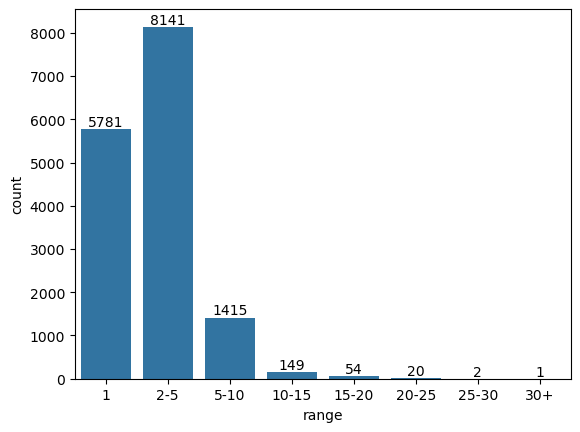

In [85]:
sns.barplot(data=assistment_prob_count_bin, x='range', y='count')
# label each bar with the count
for index, row in assistment_prob_count_bin.iterrows():
    plt.text(row['range'], row['count'], row['count'], ha='center', va='bottom')
plt.show()

### Pure TXT problem

In [86]:
txt_problem = problem[problem['assist_contain_pix'] == 0]

In [88]:
txt_problem.problem_type.value_counts()

problem_type
open_response          3027
numeric                2726
choose_1               1174
fill_in_ignore_case     232
algebra                 217
old_algebra              96
numeric_expression       78
choose_n                 61
fill_in_1                14
fraction_reduced         14
rank                     11
Name: count, dtype: int64

In [100]:
def inspect_body(df: pd.DataFrame, problem_type: str) -> None:
    print('Inspecting problems of type: ', problem_type)
    df = df[df.problem_type == problem_type]
    text = df.body_text.to_numpy()
    text_id = df.problem_id.to_numpy()
    for k, v in zip(text_id, text):
        print("%d: %s" % (k, v))
    print('Total number of problems: ', len(text))

In [104]:
inspect_body(txt_problem, 'open_response')

Inspecting problems of type:  open_response
1601585: Explain your reasoning.
1226153: Mark the text by underlining key words. The sum of 25 and h is divided by f cubed.
1601866: Explain your reasoning.
1459782: If true, find a value that would result in a false number sentence. If false, find a value that would result in a true number sentence.
1228599: Find the solution to the equation below using tape diagrams. Check your answer. m - 7 = 17 Submit your tape diagram using the tools below.
1459784: If true, find a value that would result in a false number sentence. If false, find a value that would result in a true number sentence.
1459785: If true, find a value that would result in a false number sentence. If false, find a value that would result in a true number sentence.
1228601: Find the solution to the equation below using tape diagrams. Check your answer. p + 8 = 18 Submit your tape diagram using the tools below.
1054354: Find the rate. 360 customers in 30 days
1054355: Find the 

In [101]:
inspect_body(txt_problem, 'numeric')

Inspecting problems of type:  numeric
1601582: What is 1% of 75?
1601583: What is 0.1% of 75?
1601584: What is 0.5% of 75?
1601581: What is 10% of 75?
1601867: What was the error, expressed in inches? Do not include units in your answer.
1601868: What was the error, expressed as a percentage of the actual height? Do not include the percent sign (%) in your answer.
1459815: Find the answer to the variable j that would make this equation correct. j+ 12 = 25
1525816: An elevator travels 310 feet in 10 seconds. At that speed, how far (in feet) can this elevator travel in 12 seconds? Do not include units (feet) in your answer.
1601921: Lin's sister has a checking account. If the account balance ever falls below zero, the bank charges her a fee of $5.95 per day. Today, the balance in Lin's sister's account is -$2.67. If she does not make any deposits or withdrawals, what will be the balance in her account after 2 days? Do not include units ($) in your answer.
1627226: How long does it take t

In [102]:
inspect_body(txt_problem, 'choose_1')

Inspecting problems of type:  choose_1
1601865: Clare estimates that her brother is 4 feet tall. When they get measured at the doctor’s office, her brother’s actual height is 4 feet, 2 inches. Should Clare's or the doctor's measurement be considered the actual height?
1459780: Substitute the value for the variable, and state in a complete sentence whether the resulting number sentence is true or false. 20 > 86 − h. Substitute 46 for h.
1459778: Substitute the value for the variable, and state in a complete sentence whether the resulting number sentence is true or false. 15a ≥ 75. Substitute 5 for a.
1459781: Substitute the value for the variable, and state in a complete sentence whether the resulting number sentence is true or false. 32 ≥ 8m. Substitute 5 for m.
1219524: Ashley and Brandon have different methods for finding square roots. Ashley's Method: To find the square root of x , find a number so that the product of the number and itself is x . For example, 2 · 2 = 4, so the squar

In [103]:
inspect_body(txt_problem, 'algebra')

Inspecting problems of type:  algebra
1437691: Write an expression using variables and numbers for the statement. Use the ^ symbol to represent an exponent. For example: 5 2 should be typed as 5^2
1226154: Write an expression using variables and/or numbers for the statement. Omaya picked x amount of apples, took a break, and then picked v more. Write the expression that models the total number of apples Omaya picked.
1226155: Write an expression using variables and/or numbers for the statement. A number h is tripled and then decreased by 8.
1226156: Write an expression using variables and/or numbers for the statement. Remember to use parenthesis where necessary. Sidney brought s carrots to school and combined them with Jenan’s j carrots. She then splits them equally among 8 friends.
1226157: Write an expression using variables and/or numbers for the statement. 15 less than the quotient of e and d
1226158: Write an expression using variables and/or numbers for the statement. Marissa’s h

### Saving

In [202]:
problem.to_csv(os.path.join(PROJECT_ROOT, DATA_PRO, QC23_prob_pro + CSV), index=False)

In [138]:
skill_code.to_csv(os.path.join(PROJECT_ROOT, DATA_PRO, 'qc23_skill_code.csv'), index=False)

In [139]:
txt_problem.to_csv(os.path.join(PROJECT_ROOT, DATA_PRO, 'qc23_txt_problem.csv'), index=False)

In [203]:
problem_pro = pd.read_csv(os.path.join(PROJECT_ROOT, DATA_PRO, QC23_prob_pro + CSV))

In [204]:
problem_pro

,problem_id,assistment_id,problem_type,body_text,body_type,concate_skill_code,concate_skill_name,is_multi_skill,assist_text,assist_type,assist_contain_pix
0,1601582,1126761,numeric,What is 1% of 75?,TXT,7.RP.A.3,Use Proportional Relationships to Solve Ratio ...,0,What is 1% of 75? [SEP] Explain your reasoning.,TXT [SEP] TXT,0
1,1601583,1126762,numeric,What is 0.1% of 75?,TXT,7.RP.A.3,Use Proportional Relationships to Solve Ratio ...,0,What is 0.1% of 75? [SEP] Explain your reasoning.,TXT [SEP] TXT,0
2,1601584,1126763,numeric,What is 0.5% of 75?,TXT,7.RP.A.3,Use Proportional Relationships to Solve Ratio ...,0,What is 0.5% of 75? [SEP] Explain your reasoning.,TXT [SEP] TXT,0
3,1601581,1126760,numeric,What is 10% of 75?,TXT,7.RP.A.3,Use Proportional Relationships to Solve Ratio ...,0,What is 10% of 75? [SEP] Explain your reasoning.,TXT [SEP] TXT,0
4,1601585,1126760,open_response,Explain your reasoning.,TXT,7.RP.A.3,Use Proportional Relationships to Solve Ratio ...,0,What is 10% of 75? [SEP] Explain your reasoning.,TXT [SEP] TXT,0
...,...,...,...,...,...,...,...,...,...,...,...
38565,1386267,970101,open_response,"In an amusement park, there is a small Ferris ...",PIX,HSF.IF.C.7e,"Graph Exponential, Logarithmic & Trigonometric...",0,Find a formula for a function that models the ...,PIX [SEP] TXT [SEP] PIX,1
38566,2076057,719204,open_response,Show your work. Submit your array using the to...,TXT,7.EE.A.1 [SEP] 7.EE.A.2,Apply Properties of Operations to Create Equiv...,1,Use a rectangular array to write the expressio...,PIX [SEP] PIX [SEP] TXT [SEP] TXT,1
38567,2059592,1415357,fraction_reduced,Now solve. _______ Leave your answer as a mixe...,PIX,4.NF.B.3c-2,Subtract Mixed Numbers with Like Denominators,0,Now solve. _______ Leave your answer as a mixe...,PIX,1
38568,2059596,1415359,fraction_reduced,Now solve. _______ Leave your answer as a mixe...,PIX,4.NF.B.3c-2,Subtract Mixed Numbers with Like Denominators,0,Now solve. _______ Leave your answer as a mixe...,PIX,1


In [205]:
problem_pro.problem_id.nunique()

38570

In [206]:
problem_pro.assistment_id.nunique()

15563

In [207]:
problem_pro.body_type.value_counts()

body_type
TXT    19720
PIX    18850
Name: count, dtype: int64

In [208]:
problem_pro.problem_type.value_counts()

problem_type
open_response          19536
numeric                11148
choose_1                4550
fill_in_ignore_case     1168
algebra                  778
old_algebra              544
choose_n                 330
fraction_reduced         215
numeric_expression       171
fill_in_1                 79
rank                      51
Name: count, dtype: int64

In [209]:
problem_pro.assist_contain_pix.value_counts()

assist_contain_pix
1    30920
0     7650
Name: count, dtype: int64